# March Machine Learning Mania 2017

https://www.kaggle.com/c/march-machine-learning-mania-2017/overview

### What to predict

Stage 1 - You should submit predicted probabilities for every possible matchup in the past 4 NCAA tournaments (2013-2016).

Stage 2 - You should submit predicted probabilities for every possible matchup before the 2017 tournament begins.

Refer to the Timeline page for specific dates. In both stages, the sample submission will tell you which games to predict.

### About March madness

 - Tournament is made of 64 teams competing in Single Elimination Format.
 - To win the championship, team has to win 6 consecutive games. 
 - Tournament is broken into 4 regions. Each region has 16 teams, ranked from 1 - 16. This is determined by NCAA committee
 - Games are structured so that HIghest Seed in a region plays Lowest seed, 2<sup>nd</sup> highest plays with 2<sup>nd</sup> lowest and so on.
 - 

## Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
seasons_path = './data/seasons.csv'
teams_path = './data/teams.csv'
reg_season_compact_results_path = './data/RegularSeasonCompactResults.csv'
reg_season_detailed_results_path = './data/RegularSeasonDetailedResults.csv'
tourney_compact_results_path = './data/TourneyCompactResults.csv'
tourney_detailed_results_path = './data/TourneyDetailedResults.csv'
tourney_seeds_path = './data/TourneySeeds.csv'
tourney_slots_path = './data/TourneySlots.csv'

In [3]:
seasons_df = pd.read_csv(seasons_path)
teams_df = pd.read_csv(teams_path)
RSCR_df = pd.read_csv(reg_season_compact_results_path)
RSDR_df = pd.read_csv(reg_season_detailed_results_path)
tcr_df = pd.read_csv(tourney_compact_results_path)
tdr_df = pd.read_csv(tourney_detailed_results_path)
tseeds_df = pd.read_csv(tourney_seeds_path)
tslots_df = pd.read_csv(tourney_slots_path)

### Data Descriptions

***Seasons***

This file identifies the different seasons included in the historical data, along with certain season-level properties.

 - "season" - indicates the year in which the tournament was played
 - "dayzero" - tells you the date corresponding to daynum=0 during that season. All game dates have been aligned upon a common scale so that the championship game of the final tournament is on daynum=154. Working backward, the national semifinals are always on daynum=152, the "play-in" games are on days 134/135, Selection Sunday is on day 132, and so on. All game data includes the day number in order to make it easier to perform date calculations. If you really want to know the exact date a game was played on, you can combine the game's "daynum" with the season's "dayzero". For instance, since day zero during the 2011-2012 season was 10/31/2011, if we know that the earliest regular season games that year were played on daynum=7, they were therefore played on 11/07/2011.
 - "regionW/X/Y/Z" - by convention, the four regions in the final tournament are always named W, X, Y, and Z. 
    - Whichever region's name comes first alphabetically, that region will be Region W. And whichever Region plays against Region W in the national semifinals, that will be Region X. 
    - For the other two regions, whichever region's name comes first alphabetically, that region will be Region Y, and the other will be Region Z. 
    - This allows us to identify the regions and brackets in a standardized way in other files. For instance, 
    - during the 2012 tournament, the four regions were East, Midwest, South, and West. 
    - Being the first alphabetically, East becomes W. 
    - Since the East regional champion (Ohio State) played against the Midwest regional champion (Kansas) in the national semifinals, that makes Midwest be region X. 
    - For the other two (South and West), since South comes first alphabetically, that makes South Y and therefore West is Z. So for this season, the W/X/Y/Z are East,Midwest,South,West.

In [4]:
seasons_df.head()

,Season,Dayzero,Regionw,Regionx,Regiony,Regionz
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


***Teams***

This file identifies the different college teams present in the dataset. Each team has a 4 digit id number.

In [5]:
teams_df.head()
#len(teams_df['Team_Name'])

,Team_Id,Team_Name
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


***RegularSeasonCompactResults***

This file identifies the game-by-game results for 32 seasons of historical data, from 1985 to 2015. Each year, it includes all games played from daynum 0 through 132 (which by definition is "Selection Sunday," the day that tournament pairings are announced). Each row in the file represents a single game played.

 - "season" - this is the year of the associated entry in seasons.csv (the year in which the final tournament occurs)
 - "daynum" - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "dayzero" date in the "seasons.csv" file. For example, the first game in the file was daynum=20. Combined with the fact from the "season.csv" file that day zero was 10/29/1984, that means the first game was played 20 days later, or 11/18/1984. There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key. In order to accomplish this uniqueness, we had to adjust one game's date. In March 2008, the SEC postseason tournament had to reschedule one game (Georgia-Kentucky) to a subsequent day, so Georgia had to actually play two games on the same day. In order to enforce this uniqueness, we moved the game date for the Georgia-Kentucky game back to its original date.
 - "wteam" - this identifies the id number of the team that won the game, as listed in the "teams.csv" file. No matter whether the game was won by the home team or visiting team, "wteam" always identifies the winning team.
 - "wscore" - this identifies the number of points scored by the winning team.
 - "lteam" - this identifies the id number of the team that lost the game.
 - "lscore" - this identifies the number of points scored by the losing team.
 - "numot" - this indicates the number of overtime periods in the game, an integer 0 or higher.
 - "wloc" - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting team, this value will be "A". If it was played on a neutral court, then this value will be "N". Sometimes it is unclear whether the site should be considered neutral, since it is near one team's home court, or even on their court during a tournament, but for this determination we have simply used the Kenneth Massey data in its current state, where the "@" sign is either listed with the winning team, the losing team, or neither team.

In [6]:
RSCR_df.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


***RegularSeasonDetailedResults***

This file is a more detailed set of game results, covering seasons 2003-2016. This includes team-level total statistics for each game (total field goals attempted, offensive rebounds, etc.) The column names should be self-explanatory to basketball fans (as above, "w" or "l" refers to the winning or losing team):

 - wfgm - field goals made
 - wfga - field goals attempted
 - wfgm3 - three pointers made
 - wfga3 - three pointers attempted
 - wftm - free throws made
 - wfta - free throws attempted
 - wor - offensive rebounds
 - wdr - defensive rebounds
 - wast - assists
 - wto - turnovers
 - wstl - steals
 - wblk - blocks
 - wpf - personal fouls

In [7]:
RSDR_df.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


***TourneyCompactResults***

This file identifies the game-by-game NCAA tournament results for all seasons of historical data. The data is formatted exactly like the regular_season_compact_results.csv data. 

Note that these games also include the play-in games (which always occurred on day 134/135) for those years that had play-in games.

In [8]:
tcr_df.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


***TourneyDetailedResults***

This file contains the more detailed results for tournament games from 2003 onward.

In [9]:
tdr_df.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


***TourneySeeds***

This file identifies the seeds for all teams in each NCAA tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on the bracket structure.

 - "season" - the year
 - "seed" - this is a 3/4-character identifier of the seed, 
             where the first character is either W, X, Y, or Z (identifying the region the team was in) and 
             the next two digits (either 01, 02, ..., 15, or 16) tells you the seed within the region. 
     
     For play-in teams, there is a fourth character (a or b) to further distinguish the seeds, since teams that face each other in the play-in games will have the same first three characters. 
     For example, the first record in the file is seed W01, which means we are looking at the #1 seed in the W region (which we can see from the "seasons.csv" file was the East region). 
     This seed is also referenced in the "tourney_slots.csv" file that tells us which bracket slots face which other bracket slots in which rounds.
 - "team" - this identifies the id number of the team, as specified in the teams.csv file.

In [10]:
tseeds_df.head()

,Season,Seed,Team
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


***TourneySlots***

This file identifies the mechanism by which teams are paired against each other, depending upon their seeds. Because of the existence of play-in games for particular seed numbers, the pairings have small differences from year to year. If there were N teams in the tournament during a particular year, there were N-1 teams eliminated (leaving one champion) and therefore N-1 games played, as well as N-1 slots in the tournament bracket, and thus there will be N-1 records in this file for that season.

 - "season" - the year
 - "slot" - this uniquely identifies one of the tournament games. For play-in games, it is a three-character string identifying the seed fulfilled by the winning team, such as W16 or Z13. For regular tournament games, it is a four-character string, where the first two characters tell you which round the game is (R1, R2, R3, R4, R5, or R6) and the second two characters tell you the expected seed of the favored team. Thus the first row is R1W1, identifying the Round 1 game played in the W bracket, where the favored team is the 1 seed. As a further example, the R2W1 slot indicates the Round 2 game that would have the 1 seed from the W bracket, assuming that all favored teams have won up to that point. The slot names are different for the final two rounds, where R5WX identifies the national semifinal game between the winners of regions W and X, and R5YZ identifies the national semifinal game between the winners of regions Y and Z, and R6CH identifies the championship game. The "slot" value is used in other columns in order to represent the advancement and pairings of winners of previous games.
 - "strongseed" - this indicates the expected stronger-seeded team that plays in this game. For Round 1 games, a team seed is identified in this column (as listed in the "seed" column in the tourney_seeds.csv file), whereas for subsequent games, a slot is identified in this column. In the first record of this file (slot R1W1), we see that seed W01 is the "strongseed", which during the 1985 tournament would have been Georgetown. Whereas for games from Round 2 or later, rather than a team seed, we will see a "slot" referenced in this column. So in the 33rd record of this file (slot R2W1), it tells us that the winners of slots R1W1 and R1W8 will face each other in Round 2. Of course, in the last few games of the tournament - the national semifinals and finals - it's not really meaningful to talk about a "strong seed" or "weak seed", but those games are represented in the same format for the sake of uniformity.
 - "weakseed" - this indicates the expected weaker-seeded team that plays in this game, assuming all favored teams have won so far. For Round 1 games, a team seed is identified in this column (as listed in the "seed" column in the tourney_seeds.csv file), whereas for subsequent games, a slot is identified in this column.

In [11]:
tslots_df.head()

,Season,Slot,Strongseed,Weakseed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14
3,1985,R1W4,W04,W13
4,1985,R1W5,W05,W12


In [12]:
teams_df.shape

(364, 2)

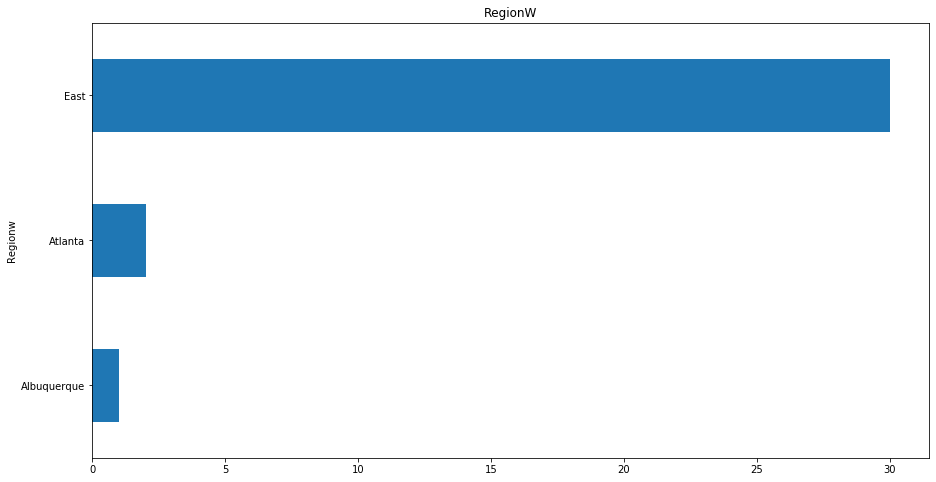

In [12]:
seasons_df['counterw'] = 1
seasons_df.groupby('Regionw')['counterw'].count().sort_values().plot(kind='barh',title='RegionW',figsize=(15, 8))
plt.show()

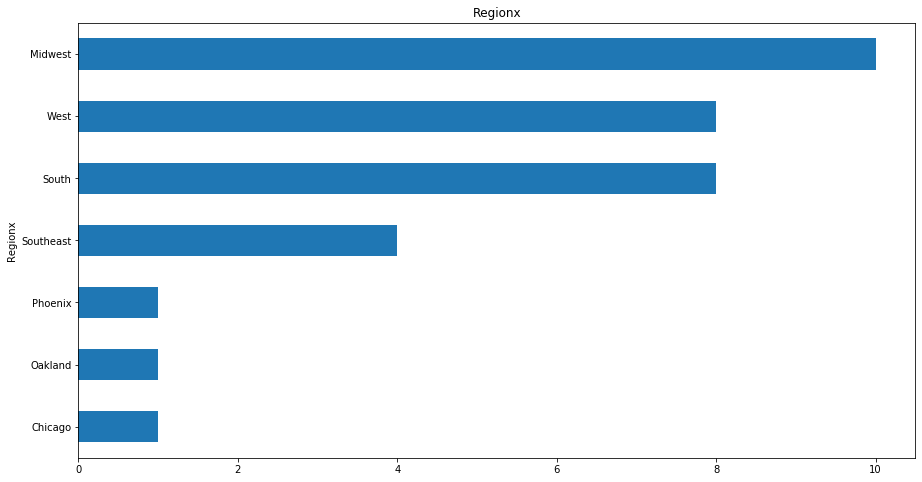

In [13]:
seasons_df['counterx'] = 1
seasons_df.groupby('Regionx')['counterx'].count().sort_values().plot(kind='barh',title='Regionx',figsize=(15, 8))
plt.show()

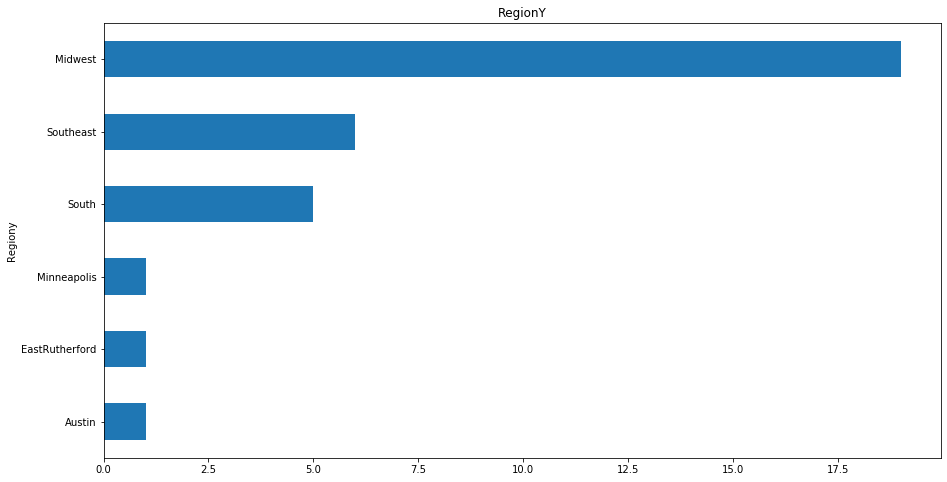

In [14]:
seasons_df['countery'] = 1
seasons_df.groupby('Regiony')['countery'].count().sort_values().plot(kind='barh',title='RegionY',figsize=(15, 8))
plt.show()

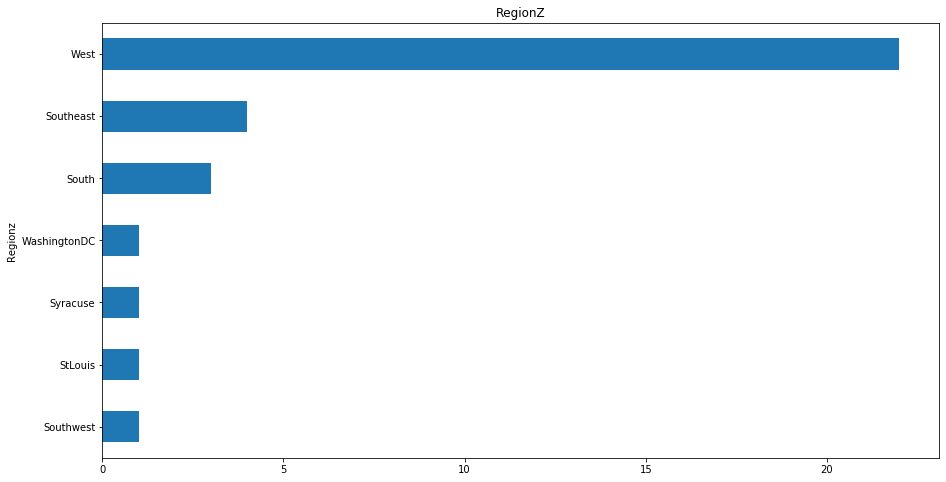

In [15]:
seasons_df['counterz'] = 1
seasons_df.groupby('Regionz')['counterz'].count().sort_values().plot(kind='barh',title='RegionZ',figsize=(15, 8))
plt.show()

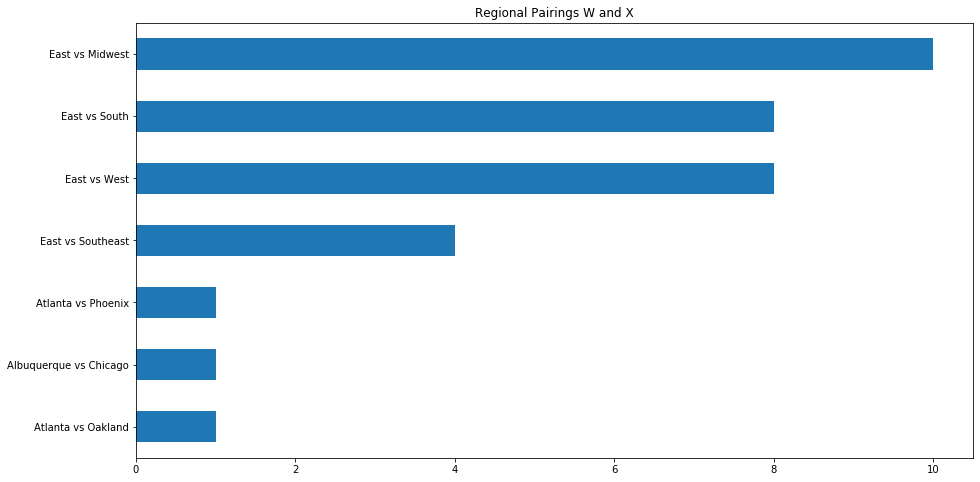

In [16]:
#--- most frequent regional Pairings
pairingsDF = seasons_df.copy()
pairingsDF['W vs X'] = seasons_df['Regionw'] + ' vs ' + seasons_df['Regionx']
pairingsDF['Y vs Z'] = seasons_df['Regiony'] + ' vs ' + seasons_df['Regionz']
pairingsDF = pairingsDF[['Season','W vs X','Y vs Z']]
pairingsDF['W vs X'].value_counts().sort_values().plot(kind='barh',title='Regional Pairings W and X',figsize=(15, 8))
plt.show()

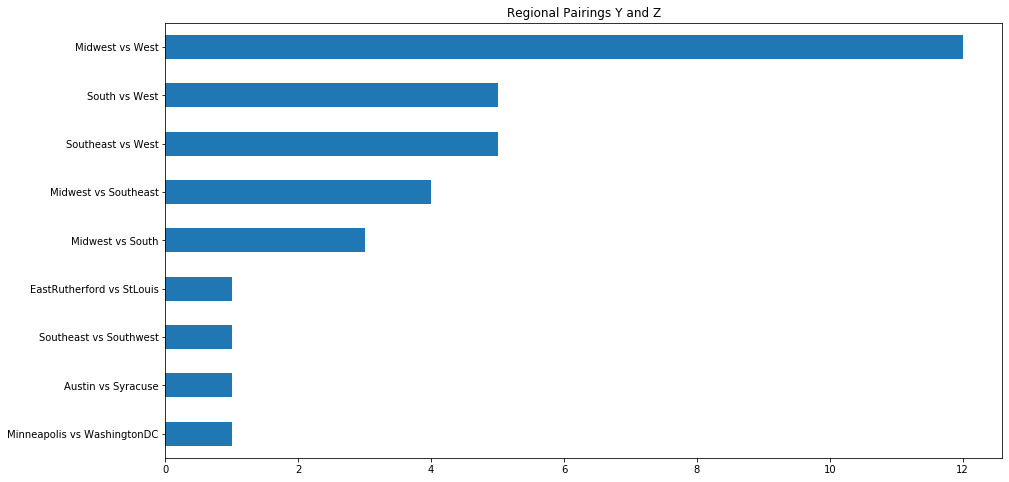

In [17]:
pairingsDF['Y vs Z'].value_counts().sort_values().plot(kind='barh',title='Regional Pairings Y and Z',figsize=(15, 8))
plt.show()

In [18]:
#--- seasons days
print('max : ',max(RSCR_df['Daynum']))
print('min : ',min(RSCR_df['Daynum']))
print('total Season days : ', max(RSCR_df['Daynum']) - min(RSCR_df['Daynum']))

max :  132
min :  0
total Season days :  132


In [19]:
#---winning teams every season
max_day = max(RSCR_df['Daynum'])
seasons_winning_teams = RSCR_df[RSCR_df['Daynum'] == max_day]['Wteam']
seasons_losing_teams = RSCR_df[RSCR_df['Daynum'] == max_day]['Lteam']
no_teams = len(RSCR_df[RSCR_df['Daynum'] == max_day])
print('teams played on season_finale every season - ',no_teams)
#print('Team with most season wins : ',seasons_winning_teams.value_counts())

teams played on season_finale every season -  191


In [20]:
seasons_losing_teams.value_counts()
teams_df[teams_df['Team_Id'] == 1314]
#teams with most season wins in finals (1985 - 2017) = 16 - 1246 - Kentucky
#teams with most season loss in finals = 11 - 1314 - North Carolina
#print('Team with most season wins : ',seasons_winning_teams.value_counts())

,Team_Id,Team_Name
213,1314,North Carolina


In [21]:
#--- tournament days
print('max : ',max(tcr_df['Daynum']))
print('min : ',min(tcr_df['Daynum']))
print('total tournament days : ', max(tcr_df['Daynum']) - min(tcr_df['Daynum']))

max :  154
min :  134
total tournament days :  20


In [22]:
#---tournaments
max_day = max(tcr_df['Daynum'])
tourney_winning_teams = tcr_df[tcr_df['Daynum'] ==  max_day]['Wteam']
tourney_losing_teams = tcr_df[tcr_df['Daynum'] ==  max_day]['Lteam']
print('teams played on Tourney_finale every Tournament - ',len(tcr_df[tcr_df['Daynum'] ==  max_day]))
tcr_df[tcr_df['Daynum'] ==  max_day]

teams played on Tourney_finale every Tournament -  32


,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
62,1985,154,1437,66,1207,64,N,0
125,1986,154,1257,72,1181,69,N,0
188,1987,154,1231,74,1393,73,N,0
251,1988,154,1242,83,1328,79,N,0
314,1989,154,1276,80,1371,79,N,1
377,1990,154,1424,103,1181,73,N,0
440,1991,154,1181,72,1242,65,N,0
503,1992,154,1181,71,1276,51,N,0
566,1993,154,1314,77,1276,71,N,0
629,1994,154,1116,76,1181,72,N,0


In [23]:
tourney_losing_teams.value_counts()
teams_df[teams_df['Team_Id'] == 1242]
# (1985 - 2016) - most wins in final  = 1181 = Duke university - 5
# (1985 - 2016) - 2nd most wins in final  = 1163 = Connecticut - 4
# (1985 - 2016) - most loss in final  = 1181 = Duke university - 4
# (1985 - 2016) - 2nd most loss in final  = 1276 = Michigan - 3
# (1985 - 2016) - 2nd most loss in final  = 1242 = Kansas - 3
# looks like duke have 
#print('Team with most season wins : ',seasons_winning_teams.value_counts())

,Team_Id,Team_Name
141,1242,Kansas


In [24]:
qSeason = 1985
#tslots_df[tslots_df['Slot'] == 'R6CH']
round_5_WX_Win = tslots_df[(tslots_df['Slot'] == 'R6CH')&(tslots_df['Season'] == qSeason)]['Strongseed']
round_5_YZ_Win = tslots_df[(tslots_df['Slot'] == 'R6CH')&(tslots_df['Season'] == qSeason)]['Weakseed']
round_4_WX = tslots_df[(tslots_df['Slot'] == 'R5WX')&(tslots_df['Season'] == qSeason)]['Strongseed']
round_4_YZ = tslots_df[(tslots_df['Slot'] == 'R5YZ')&(tslots_df['Season'] == qSeason)]['Weakseed']
tslots_df[tslots_df['Slot'] == 'R5WX']
tslots_df[tslots_df['Slot'] == 'R5YZ']
tslots_df[tslots_df['Slot'] == 'R4W1']
#tslots_df['Slot'].unique()

,Season,Slot,Strongseed,Weakseed
56,1985,R4W1,R3W1,R3W2
119,1986,R4W1,R3W1,R3W2
182,1987,R4W1,R3W1,R3W2
245,1988,R4W1,R3W1,R3W2
308,1989,R4W1,R3W1,R3W2
371,1990,R4W1,R3W1,R3W2
434,1991,R4W1,R3W1,R3W2
497,1992,R4W1,R3W1,R3W2
560,1993,R4W1,R3W1,R3W2
623,1994,R4W1,R3W1,R3W2


In [25]:
seedsInt_df['s_value'] = tseeds_df['Seed'].str[1:3].apply(pd.to_numeric)

NameError: name 'seedsInt_df' is not defined

In [26]:
def getTeamName(teamId):
    return teams_df[teams_df['Team_Id'] == teamId]['Team_Name'].values[0]

In [27]:
teams_df[teams_df['Team_Id'] == 1242]['Team_Name'].values[0]

'Kansas'

In [28]:
RSCR_df.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [29]:
RSCR_df = RSCR_df.merge(teams_df[['Team_Name','Team_Id']],
                       left_on = 'Wteam',
                       right_on = 'Team_Id',
                       validate='many_to_one').drop('Team_Id', axis=1).rename(columns={'Team_Name': 'WTeamName'}).merge(teams_df[['Team_Name','Team_Id']],
                       left_on = 'Lteam',
                       right_on = 'Team_Id',
                       validate='many_to_one').drop('Team_Id', axis=1).rename(columns={'Team_Name': 'LTeamName'})

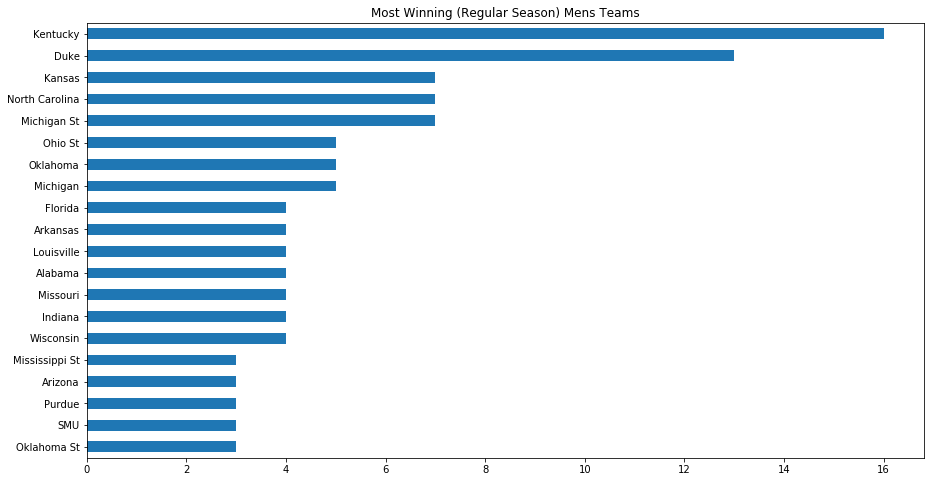

In [30]:
max_day = max(RSCR_df['Daynum'])
season_finale_df = RSCR_df[RSCR_df['Daynum'] ==  max_day]
season_finale_df['WTeamName'].value_counts().sort_values().tail(20).plot(kind='barh',title='Most Winning (Regular Season) Mens Teams',figsize=(15, 8))
plt.show()

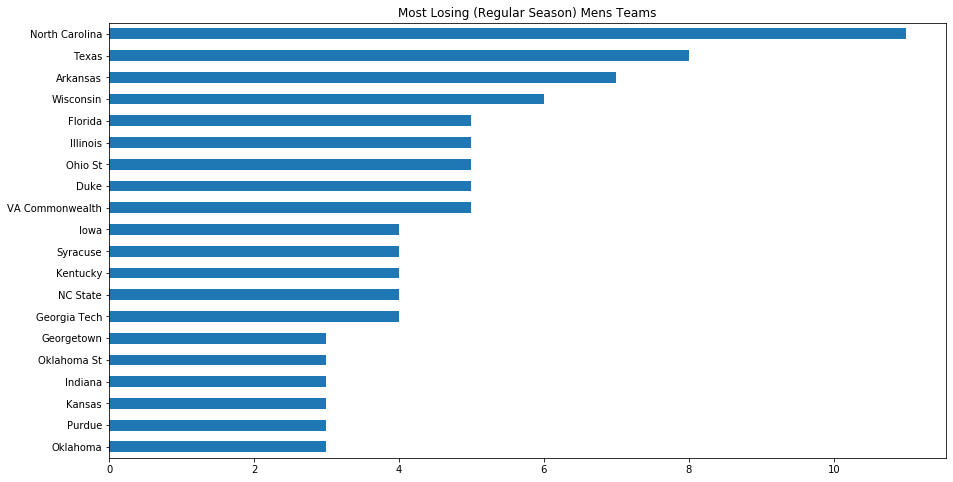

In [31]:
season_finale_df['LTeamName'].value_counts().sort_values().tail(20).plot(kind='barh',title='Most Losing (Regular Season) Mens Teams',figsize=(15, 8))
plt.show()

In [32]:
max_day = max(tcr_df['Daynum'])
max_day
tcr_df = tcr_df.merge(teams_df[['Team_Name','Team_Id']],
                       left_on = 'Wteam',
                       right_on = 'Team_Id',
                       validate='many_to_one').drop('Team_Id', axis=1).rename(columns={'Team_Name': 'WTeamName'}).merge(teams_df[['Team_Name','Team_Id']],
                       left_on = 'Lteam',
                       right_on = 'Team_Id',
                       validate='many_to_one').drop('Team_Id', axis=1).rename(columns={'Team_Name': 'LTeamName'})

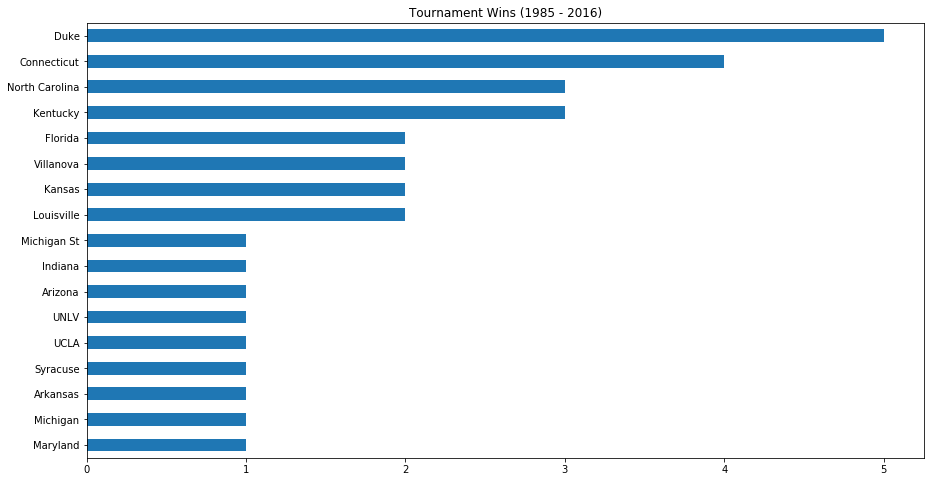

In [37]:
finalists_df = tcr_df[tcr_df['Daynum'] ==  max_day]
finalists_df['WTeamName'].value_counts().sort_values().plot(kind='barh',title='Tournament Wins (1985 - 2016)',figsize=(15, 8))
plt.show()

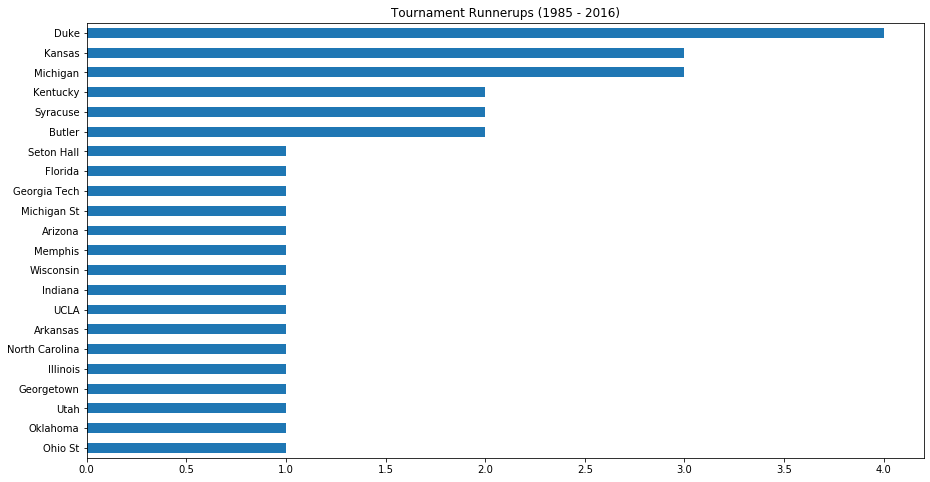

In [38]:
finalists_df['LTeamName'].value_counts().sort_values().plot(kind='barh',title='Tournament Runnerups (1985 - 2016)',figsize=(15, 8))
plt.show()

In [59]:
def getSeed(season, teamId):
    return tseeds_df[(tseeds_df['Season'] == season) & (tseeds_df['Team'] == teamId)]['Seed'].str[1:3].apply(pd.to_numeric).values[0]

In [60]:
tseeds_df.head()
season = 1985
teamId = 1208
tseeds_df[(tseeds_df['Season'] == season) & (tseeds_df['Team'] == teamId)]['Seed'].str[1:3].apply(pd.to_numeric).values[0]

6

In [63]:
finalists_df['Wseed'] = np.vectorize(getSeed)(finalists_df['Season'], finalists_df['Wteam'])
finalists_df['Lseed'] = np.vectorize(getSeed)(finalists_df['Season'], finalists_df['Lteam'])
finalists_df

C:\Users\hpendyal\AppData\Local\Continuum\anaconda3\envs\cnf-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\hpendyal\AppData\Local\Continuum\anaconda3\envs\cnf-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,WTeamName,LTeamName,Wseed,Lseed
52,2016,154,1437,77,1314,74,N,0,Villanova,North Carolina,2,1
162,1985,154,1437,66,1207,64,N,0,Villanova,Georgetown,8,1
191,1993,154,1314,77,1276,71,N,0,North Carolina,Michigan,1,1
194,1992,154,1181,71,1276,51,N,0,Duke,Michigan,1,6
197,2013,154,1257,82,1276,76,N,0,Louisville,Michigan,1,4
215,2001,154,1181,82,1112,72,N,0,Duke,Arizona,1,2
233,1994,154,1116,76,1181,72,N,0,Arkansas,Duke,1,2
237,1990,154,1424,103,1181,73,N,0,UNLV,Duke,1,3
241,1986,154,1257,72,1181,69,N,0,Louisville,Duke,2,1
253,1999,154,1163,77,1181,74,N,0,Connecticut,Duke,1,1


In [58]:
#--- title winner seeds
finalists_df['Wseed'].value_counts().sort_values().plot(kind='barh',title='Tournament Winners (1985 - 2016)',figsize=(15, 8))

52      1437
162     1437
191     1314
194     1181
197     1257
215     1181
233     1116
237     1424
241     1257
253     1163
267     1246
278     1231
291     1242
363     1268
408     1246
411     1181
418     1393
557     1163
583     1196
658     1314
734     1417
808     1314
851     1242
1064    1112
1068    1163
1242    1246
1315    1196
1352    1181
1638    1181
1644    1163
1740    1277
1780    1276
Name: Wteam, dtype: int64

### Some historic Stats from data analysis

#### Regions (1985 - 2017)
- for W - most - 30 - East
- for X - most - 10 - Midwest      
- for Y - most - 19 - Midwest           
- for Z - most - 30 - West


- for W - least - 1 - Albuquerque
- for X - least - 1 - Oakland       
- for Y - least - 1 - Minneapolis
- for Z - least - 1 - Syracuse


- for W - next_best - 2 - Atlanta
- for X - next_best - 8 - South, West   
- for Y - next_best - 6 - Southeast
- for Z - next_best - 4 - Southeast

#### For Seasons (1985 - 2017)
- teams with most season wins in finals = 16 - 1246 - Kentucky
- teams with most season loss in finals = 11 - 1314 - North Carolina



#### For Tournaments (1985 - 2016)
- most wins in final  = 1181 - Duke university - 5
- 2nd most wins in final  = 1163 - Connecticut - 4
- most loss in final  = 1181 - Duke university - 4
- 2nd most loss in final  = 1276 - Michigan - 3
- 2nd most loss in final  = 1242 - Kansas - 3

***Note*** : looks like Duke have a good record from data

### Inferences from Data Wrangling

Teams : 364 teams

seasons : 33 seasons (1985 - 2017)

season days : 132

Tournament days : 20

***Taking villanova into consideration and doing more data analysis***

Team_Name = Villanova

Team_Id = 1437

Total Regular Seasons Won = 660 from 1985 - 2017, 31 mathces won out of 34 in 2017 alone

In [73]:
#---- From 1985 lets check the number of mathces villanova played, won
print('Villanova')
seasonsPlayed = 0
for year in RSCR_df['Season'].unique():
    played = RSCR_df[(RSCR_df['Season'] == year) & ((RSCR_df['Lteam'] == 1437) | (RSCR_df['Wteam'] == 1437))]['Wscore'].count()
    won = RSCR_df[(RSCR_df['Season'] == year) & ((RSCR_df['Wteam'] == 1437))]['Wscore'].count()
    lost = played - won
    seasonsPlayed+=1
    print('In ',year,' : Played - ',played,'. Won - ',won,'. Lost - ',lost)
print('---> Participated in ',seasonsPlayed,' Seasons from 1985 - 2017')

Villanova
In  1985  : Played -  29 . Won -  19 . Lost -  10
In  1986  : Played -  34 . Won -  21 . Lost -  13
In  1987  : Played -  30 . Won -  15 . Lost -  15
In  1988  : Played -  33 . Won -  21 . Lost -  12
In  1989  : Played -  30 . Won -  15 . Lost -  15
In  1990  : Played -  32 . Won -  18 . Lost -  14
In  1991  : Played -  30 . Won -  16 . Lost -  14
In  1992  : Played -  28 . Won -  14 . Lost -  14
In  1993  : Played -  27 . Won -  8 . Lost -  19
In  1994  : Played -  27 . Won -  15 . Lost -  12
In  1995  : Played -  31 . Won -  24 . Lost -  7
In  1996  : Played -  31 . Won -  25 . Lost -  6
In  1997  : Played -  31 . Won -  22 . Lost -  9
In  1998  : Played -  29 . Won -  12 . Lost -  17
In  1999  : Played -  30 . Won -  20 . Lost -  10
In  2000  : Played -  31 . Won -  19 . Lost -  12
In  2001  : Played -  30 . Won -  18 . Lost -  12
In  2002  : Played -  29 . Won -  17 . Lost -  12
In  2003  : Played -  30 . Won -  15 . Lost -  15
In  2004  : Played -  30 . Won -  15 . Lost 

In [86]:
#--- tournaments
seasonsPlayed = 0
for year in tcr_df['Season'].unique():
    played = tcr_df[(tcr_df['Season'] == year) & ((tcr_df['Lteam'] == 1437) | (tcr_df['Wteam'] == 1437))]['Wscore'].count()
    won = tcr_df[(tcr_df['Season'] == year) & ((tcr_df['Wteam'] == 1437))]['Wscore'].count()
    lost = played - won
    if played!=0:
        seasonsPlayed+=1
        print('In ',year,' : Played - ',played,'. Won - ',won,'. Lost - ',lost)
print('---> Participated in ',seasonsPlayed,' Tournaments from 1985 - 2016')

In  1985  : Played -  6 . Won -  6 . Lost -  0
In  1986  : Played -  2 . Won -  1 . Lost -  1
In  1988  : Played -  4 . Won -  3 . Lost -  1
In  1990  : Played -  1 . Won -  0 . Lost -  1
In  1991  : Played -  2 . Won -  1 . Lost -  1
In  1995  : Played -  1 . Won -  0 . Lost -  1
In  1996  : Played -  2 . Won -  1 . Lost -  1
In  1997  : Played -  2 . Won -  1 . Lost -  1
In  1999  : Played -  1 . Won -  0 . Lost -  1
In  2005  : Played -  3 . Won -  2 . Lost -  1
In  2006  : Played -  4 . Won -  3 . Lost -  1
In  2007  : Played -  1 . Won -  0 . Lost -  1
In  2008  : Played -  3 . Won -  2 . Lost -  1
In  2009  : Played -  5 . Won -  4 . Lost -  1
In  2010  : Played -  2 . Won -  1 . Lost -  1
In  2011  : Played -  1 . Won -  0 . Lost -  1
In  2013  : Played -  1 . Won -  0 . Lost -  1
In  2014  : Played -  2 . Won -  1 . Lost -  1
In  2015  : Played -  2 . Won -  1 . Lost -  1
In  2016  : Played -  6 . Won -  6 . Lost -  0
---> Participated in  20  Tournaments from 1985 - 2016


In [84]:
#--- seeds of Villanova from 1985 - 2017
tseeds_df[tseeds_df['Team'] == 1437][['Season','Seed']]

,Season,Seed
55,1985,Z08
105,1986,Y10
229,1988,Y06
363,1990,Y12
392,1991,W09
642,1995,W03
722,1996,X03
771,1997,W04
919,1999,X08
1336,2005,Z05


In [87]:
tcr_df

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2045,2016,146,1314,88,1323,74,N,0
2046,2016,146,1393,68,1438,62,N,0
2047,2016,152,1314,83,1393,66,N,0
2048,2016,152,1437,95,1328,51,N,0
